In [307]:
# ================================================
# 1. Importar librer√≠as
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraci√≥n est√©tica
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid")

In [308]:
# ================================================
# 2. Cargar datos (funciona CSV o XLSX)
# ================================================
# Cambia el archivo seg√∫n el formato que tengas
file = "citybike_lima.csv"   # o "citybike_lima.xlsx"

if file.endswith(".csv"):
    df = pd.read_csv(file)
elif file.endswith(".xlsx"):
    df = pd.read_excel(file)

print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (5288, 17)


scrape_timestamp                        station_id  \
0  2025-10-01T11:34:22.005486-05:00  008a35afc6b4060be57b48bf90bec44c   
1  2025-10-01T11:34:22.005486-05:00  03367da30caea302b11c838d8b98df55   
2  2025-10-01T11:34:22.005486-05:00  06dd87a8b87232577015b1c9a4ba08ed   
3  2025-10-01T11:34:22.005486-05:00  0927eccbf04e2aadd179595c55c52bbe   
4  2025-10-01T11:34:22.005486-05:00  0ac132eb1a147b7b23a753185cbebd1d   

                                      station_name        lat        lon  \
0        18027 Ov. Julio Ram√≥n Riveyro - Av. Pardo -12.119013 -77.039928   
1  18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora) -12.122125 -77.011506   
2                 18024 Ov. Bolognesi - Ca. Madrid -12.123368 -77.035637   
3             18047 Malec√≥n Cisneros - Ca. Tr√≠poli -12.125037 -77.037307   
4         18026 Malec√≥n de la Marina - Parque Grau -12.118497 -77.045048   

   capacity  free_bikes  empty_slots day_of_week periodo_dia  weather_main  \
0        14           8            6   Wednesday      ma√±ana           NaN   
1        16           8            8   Wednesday      ma√±ana           NaN   
2        14           3           11   Wednesday      ma√±ana           NaN   
3        16           9            7   Wednesday      ma√±ana           NaN   
4        20          11            9   Wednesday      ma√±ana           NaN   

   weather_desc  temp_C  wind_speed              clima_miraflores  \
0           NaN    19.0         NaN  Clima: pron√≥stico del tiempo   
1           NaN    19.0         NaN  Clima: pron√≥stico del tiempo   
2           NaN    19.0         NaN  Clima: pron√≥stico del tiempo   
3           NaN    19.0         NaN  Clima: pron√≥stico del tiempo   
4           NaN    19.0         NaN  Clima: pron√≥stico del tiempo   

   temp_miraflores  in_miraflores  
0             19.0           True  
1             19.0          False  
2             19.0           True  
3             19.0           True  
4             19.0           True

In [309]:
# ================================================
# 3. Revisi√≥n inicial
# ================================================
print("\nTipos de datos:")
print(df.dtypes)

print("\nNulos por columna:")
print(df.isnull().sum())

print("\nDuplicados:", df.duplicated().sum())




Tipos de datos:
scrape_timestamp     object
station_id           object
station_name         object
lat                 float64
lon                 float64
capacity              int64
free_bikes            int64
empty_slots           int64
day_of_week          object
periodo_dia          object
weather_main        float64
weather_desc        float64
temp_C              float64
wind_speed          float64
clima_miraflores     object
temp_miraflores     float64
in_miraflores          bool
dtype: object

Nulos por columna:
scrape_timestamp       0
station_id             0
station_name           0
lat                    0
lon                    0
capacity               0
free_bikes             0
empty_slots            0
day_of_week            0
periodo_dia            0
weather_main        5288
weather_desc        5288
temp_C                 0
wind_speed          5288
clima_miraflores       0
temp_miraflores        0
in_miraflores          0
dtype: int64

Duplicados: 0


In [310]:
# Renombrar variables clave
df = df.rename(columns={
    "scrape_timestamp": "timestamp",
    "station_id": "id_estacion",
    "station_name": "nombre_estacion",
    "lat": "latitud",
    "lon": "longitud",
    "capacity": "capacidad",
    "free_bikes": "bicis_libres",
    "empty_slots": "espacios_vacios",
    "day_of_week": "dia_semana",
    "weather_main": "clima_general",
    "weather_desc": "clima_detalle",
    "temp_C": "temp_c",
    "wind_speed": "vel_viento",
    "clima_miraflores": "clima_miraflores",
    "temp_miraflores": "temp_miraflores",
    "in_miraflores": "en_miraflores"
})

# No eliminar filas si clima est√° vac√≠o ‚Üí solo no usar esas columnas
df = df.dropna(subset=["bicis_libres", "espacios_vacios", "capacidad"])
df["dia_semana"] = df["dia_semana"].astype(str).str.strip()

# tipos num√©ricos
for c in ['bicis_libres','capacidad','espacios_vacios','temp_c','lat','lon']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Crear variable de ocupaci√≥n
df["ocupacion"] = df["bicis_libres"] / df["capacidad"]
df["ocupacion"] = df["ocupacion"].clip(0, 1)
df["ocupacion"] = df["ocupacion"].round(2)

In [311]:
# Timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
else:
    raise KeyError("‚ö†Ô∏è No se encontr√≥ la columna de timestamp")

df["hora"] = df["timestamp"].dt.hour
df["fecha"] = df["timestamp"].dt.date

# Si no hay d√≠a de semana expl√≠cito, derivarlo
if df["dia_semana"].nunique() <= 1:
    df["dia_semana"] = df["timestamp"].dt.day_name(locale="es_ES")
    df["dia_semana"] = df["dia_semana"].str.slice(0,3)  # Lun, Mar, etc.
    dias_orden = ["Lun", "Mar", "Mi√©", "Jue", "Vie", "S√°b", "Dom"]
    df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=dias_orden, ordered=True)
# ocupacion safe
df['ocupacion'] = np.where(df['capacidad']>0, df['bicis_libres']/df['capacidad'], np.nan)
df['ocupacion'] = df['ocupacion'].clip(0,1)


In [312]:
# ================================================
# 7. Estad√≠sticas descriptivas
# ================================================
print("\nResumen estad√≠stico:")
print(df.describe(include="all"))



Resumen estad√≠stico:
                                  timestamp                       id_estacion  \
count                                  5288                              5288   
unique                                  NaN                                51   
top                                     NaN  008a35afc6b4060be57b48bf90bec44c   
freq                                    NaN                               105   
mean    2025-10-02 15:52:40.524101376-05:00                               NaN   
min        2025-10-01 11:34:22.005486-05:00                               NaN   
25%     2025-10-02 01:22:40.491671040-05:00                               NaN   
50%     2025-10-02 15:16:24.257547008-05:00                               NaN   
75%     2025-10-03 06:38:44.109725952-05:00                               NaN   
max        2025-10-03 22:43:10.245499-05:00                               NaN   
std                                     NaN                               NaN   

    

In [313]:
# ================================================
# 8. An√°lisis por estaci√≥n
# ================================================
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=("nombre_estacion", "first"),
    obs=("id_estacion","count"),
    bicis_promedio=("bicis_libres","mean"),
    capacidad_promedio=("capacidad","mean"),
    ocupacion_promedio=("ocupacion","mean"),
    pct_vacia=("bicis_libres", lambda x: (x==0).mean()*100),
    pct_llena=("espacios_vacios", lambda x: (x==0).mean()*100),
    hora_pico=("hora", lambda x: x.value_counts().idxmax())
).reset_index()

station_summary.sort_values("pct_vacia", ascending=False).head(10)
station_summary.sort_values("pct_llena", ascending=False).head(10)
station_summary.sort_values("ocupacion_promedio").head(10)

id_estacion  \
17  6369e20f974a82f599ac39793a9ceeef   
50  eff5bc44fad7421819820f56aa6ded68   
39  b01138adb0102e1f6862bb8ba54b9721   
19  66ba95532fd0758049c624f5a08d8e4d   
21  696787ac674aad03dc56a790f1f9e6ed   
27  758f33f3320ac4a7aca286cf7e57bef4   
14  55c0bf37006a2c06875866c6e9e13156   
48  eb0b102f9e9bb933d2194064e70496ad   
26  757937ea9bcfaefaef0a20a336c024cf   
44  c87a72c82867fcd9f59503de195895b3   

                                      nombre_estacion  obs  bicis_promedio  \
17       27042 Av. P. Carriquiry - Av. Ricardo Angulo   38        0.000000   
50        18012 Ca. Ignacio La Puente - Av. Benavides  105        3.561905   
39            18014 Ca. Ramon Ribeyro - Av. Benavides  105        5.152381   
19                      18007 Ca. Schell - Av. La Paz  105        4.857143   
21                     18033 Ca. Scipi√≥n Llona Cdra.3  105        4.085714   
27             18038 Ca. Gral. Borgo√±o - Ca. Ayacucho  105        5.219048   
14  18039 Psje. Juana Alarco De Dammert - Ov. Guti...  105        4.752381   
48         18032 Ca. Gral. Suarez - Av .Angamos Oeste  105        4.780952   
26            18028 Av. Jorge Ch√°vez - Av. Jose Pardo  105        5.971429   
44               18035 Ca. Santander - Av. Santa Cruz  105        3.590476   

    capacidad_promedio  ocupacion_promedio   pct_vacia  pct_llena  hora_pico  
17                16.0            0.000000  100.000000        0.0         11  
50                20.0            0.178095    0.000000        0.0         11  
39                24.0            0.214683    0.000000        0.0         11  
19                20.0            0.242857    0.000000        0.0         11  
21                16.0            0.255357    0.952381        0.0         11  
27                20.0            0.260952    0.000000        0.0         11  
14                18.0            0.264021    0.000000        0.0         11  
48                18.0            0.265608    0.000000        0.0         11  
26                20.0            0.298571    0.000000        0.0         11  
44                12.0            0.299206    0.952381        0.0         11

In [314]:
# ================================================
# 9. Series temporales
# ================================================
total_bikes = df.groupby("timestamp")["bicis_libres"].sum()
total_bikes.plot(title="Total de bicicletas libres en el tiempo")
plt.ylabel("N√∫mero de bicicletas")
plt.show()



In [315]:

# ================================================
# 10. Distribuciones
# ================================================
# Evitar problemas si hay pocos d√≠as
# Boxplot por d√≠a de semana
if df["dia_semana"].nunique() > 1:
    sns.boxplot(x="dia_semana", y="ocupacion", data=df)
    plt.title("Tasa de ocupaci√≥n por d√≠a de semana")
    plt.show()

# Heatmap hora vs d√≠a
pivot = df.pivot_table(index="hora", columns="dia_semana", values="ocupacion", aggfunc="mean")
if not pivot.empty:
    sns.heatmap(pivot, cmap="YlGnBu")
    plt.title("Heatmap ocupaci√≥n (hora vs d√≠a)")
    plt.show()

# Bicicletas seg√∫n clima (solo si hay datos √∫tiles)
if df["clima_general"].nunique() > 1:
    sns.boxplot(x="clima_general", y="bicis_libres", data=df)
    plt.title("Bicicletas libres seg√∫n clima")
    plt.xticks(rotation=45)
    plt.show()

# Periodo del d√≠a
sns.barplot(x="periodo_dia", y="bicis_libres", data=df, estimator=np.mean)
plt.title("Bicicletas libres seg√∫n periodo del d√≠a")
plt.show()

# Miraflores vs resto
sns.boxplot(x="en_miraflores", y="ocupacion", data=df)
plt.title("Ocupaci√≥n en estaciones de Miraflores vs otras")
plt.show()




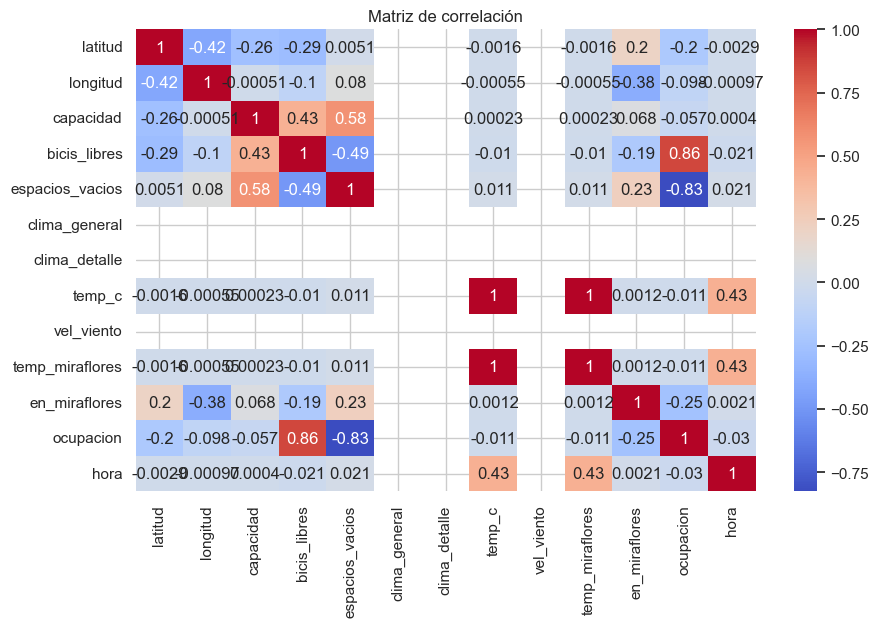

In [316]:


# ================================================
# 12. Matriz de correlaci√≥n
# ================================================
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Matriz de correlaci√≥n")
plt.show()




In [317]:
# quintiles (balance)
df['ocup_cat_q'] = pd.qcut(df['ocupacion'].dropna(), q=3, labels=['Q1','Q2','Q3'])
# categor√≠as fijas (√∫tiles operativamente)
bins = [0.15,0.35,0.55,0.75]
labels = ['Baja','Media','Alta']
df['ocup_cat_fixed'] = pd.cut(df['ocupacion'], bins=bins, labels=labels, include_lowest=True)

# --- Conteo por categor√≠a fija ---

conteo_categorias = df['ocup_cat_fixed'].value_counts().reindex(labels)
print("Conteo por categorias fijas:")
print(df['ocup_cat_fixed'].value_counts().reindex(labels))


Conteo por categorias fijas:
ocup_cat_fixed
Baja     1994
Media    2027
Alta      867
Name: count, dtype: int64


In [318]:
agg_hour = df.dropna(subset=['ocup_cat_fixed','ocupacion']).groupby(['ocup_cat_fixed','hora']).agg(
    mean_ocup=('ocupacion','mean'),
    n_obs=('ocupacion','count')
).reset_index()

pivot_hour = agg_hour.pivot(index='hora', columns='ocup_cat_fixed', values='mean_ocup')
pivot_hour.to_csv('pivot_hour_mean_ocup.csv')   # opcional: guardar
print(pivot_hour.head(24))


ocup_cat_fixed      Baja     Media      Alta
hora                                        
0               0.278867  0.430405  0.644122
1               0.282440  0.429652  0.648241
2               0.275949  0.431074  0.650372
3               0.274876  0.434165  0.643452
4               0.272720  0.436392  0.641890
5               0.272720  0.436392  0.641890
6               0.261028  0.436277  0.646755
7               0.258089  0.432789  0.633201
8               0.261561  0.447341  0.653685
9               0.270359  0.441005  0.652917
10              0.274160  0.436432  0.633024
11              0.265697  0.439207  0.650061
12              0.269595  0.436190  0.644058
13              0.278663  0.443003  0.656444
14              0.271042  0.438787  0.652631
15              0.274967  0.429792  0.654357
16              0.274283  0.435396  0.665196
17              0.258843  0.425239  0.650389
18              0.255280  0.437161  0.644563
20              0.266264  0.438560  0.657928
21        

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3533509644.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_hour = df.dropna(subset=['ocup_cat_fixed','ocupacion']).groupby(['ocup_cat_fixed','hora']).agg(


In [319]:
station_summary = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', lambda x: x.mode().iloc[0] if len(x.dropna())>0 else ""),
    obs=('timestamp','count'),
    mean_bicis=('bicis_libres','mean'),
    mean_capacidad=('capacidad','mean'),
    mean_ocupacion=('ocupacion','mean')
).reset_index()

station_summary['ocup_cat_fixed'] = pd.cut(station_summary['mean_ocupacion'].fillna(0), bins=bins, labels=labels, include_lowest=True)
station_summary.to_csv('station_summary_with_cat.csv', index=False)
station_summary.sort_values('mean_ocupacion').head(100)


id_estacion  \
17  6369e20f974a82f599ac39793a9ceeef   
50  eff5bc44fad7421819820f56aa6ded68   
39  b01138adb0102e1f6862bb8ba54b9721   
19  66ba95532fd0758049c624f5a08d8e4d   
21  696787ac674aad03dc56a790f1f9e6ed   
27  758f33f3320ac4a7aca286cf7e57bef4   
14  55c0bf37006a2c06875866c6e9e13156   
48  eb0b102f9e9bb933d2194064e70496ad   
26  757937ea9bcfaefaef0a20a336c024cf   
44  c87a72c82867fcd9f59503de195895b3   
10  409c57fe8f27975938e2e0248a4d45bc   
40  b167c074941be5e72c84b015140b95ae   
35  a08754c736d95b13253dc6e7ab0a84bf   
46  e14ff39be43b5e75c56b2be2606d3a3e   
22  6b34990c05dc96c8251a0a369cb69401   
16  5b7914e3a19e2d392967c8ff9a1eeb5e   
43  c07eaacbff9bf0e1bc77ee5fd3b14bb9   
2   06dd87a8b87232577015b1c9a4ba08ed   
23  6cc6c7fa220969e769d6ade973d20fc4   
9   3c8e489aaccbcbbe87f59457fe1901d1   
5   11c5d99df877943158c7e7c693242e26   
1   03367da30caea302b11c838d8b98df55   
37  aea4af9a353483a0761b042ca8758636   
3   0927eccbf04e2aadd179595c55c52bbe   
13  439e3845a612d6b0a61506b0ebe52a91   
25  7445571ff483b34f2e41c478e6d83588   
20  6769076dbc301448af071082f5822f8c   
8   3ab2451c995f47035d2b14590753236a   
18  6483875f7b7770a47a79c18bb17bc54e   
45  dc710115aa6014501e5b457a0b14ef25   
24  73f1bdfa0b91640c04cf7d4d17ec9bd7   
30  87d95a956d801c0953b6169325661979   
32  92f82729a1aa0e98e16bac393ddaf91b   
15  57ded81c72e11e6fc644698ee200d750   
49  edd8ff1ca69c234b86958ec42e3dd651   
36  a1c5bf0bc5ddcdb928871fbb97e89ada   
41  bb40d8da8fed6afda3b2ff8f0c59e48d   
0   008a35afc6b4060be57b48bf90bec44c   
11  4158a25459abe328f8ab8c32c0db7b6b   
38  aeddcf808d428c290c0d523999b4a298   
47  e8c7678be73f7c2febaadc3366c822ac   
4   0ac132eb1a147b7b23a753185cbebd1d   
6   1ff7b00c8a2af2eeb129df70939eb20b   
28  8301c7ecad3d99b5e04f03b87ffb8af4   
34  9b481ef2d05f69c2b56ac04ac189cc8d   
12  438d63a7c5cb69db70e9cd6665120d61   
33  9652d392478ec6d31cb23d0a2d22aa30   
42  c00d815ca6322144c5510d9f9e7121da   
7   263e9a1c4f245c4070f8c85b88d0f10d   
29  876923a9839232b31d01c19a6af87e6f   
31  88a9e07a36d29cb5801f82cedd2534b4   

                                      nombre_estacion  obs  mean_bicis  \
17       27042 Av. P. Carriquiry - Av. Ricardo Angulo   38    0.000000   
50        18012 Ca. Ignacio La Puente - Av. Benavides  105    3.561905   
39            18014 Ca. Ramon Ribeyro - Av. Benavides  105    5.152381   
19                      18007 Ca. Schell - Av. La Paz  105    4.857143   
21                     18033 Ca. Scipi√≥n Llona Cdra.3  105    4.085714   
27             18038 Ca. Gral. Borgo√±o - Ca. Ayacucho  105    5.219048   
14  18039 Psje. Juana Alarco De Dammert - Ov. Guti...  105    4.752381   
48         18032 Ca. Gral. Suarez - Av .Angamos Oeste  105    4.780952   
26            18028 Av. Jorge Ch√°vez - Av. Jose Pardo  105    5.971429   
44               18035 Ca. Santander - Av. Santa Cruz  105    3.590476   
10  18002 Ca. Oscar R. Benavides - Ov. Miraflores ...  105    6.190476   
40      18008 Ca.Lola Pardo - Ca. Mayor Arce de Oliva  105    5.571429   
35  18031 Ca. Gonzales Prada - Av. Paseo de la Rep...  105    5.276190   
46               18042 Ca. Retiro - Av. Angamos Oeste  105    5.000000   
22   18037 Av. Angamos Oeste - Parque Naciones Unidas  105    8.971429   
16                18010 Ca. Placencia - Av. Benavides  105    5.276190   
43  18025 Malec√≥n Cisneros - (Parque del Faro La M...  105    6.628571   
2                    18024 Ov. Bolognesi - Ca. Madrid  105    4.714286   
23                18003 Av.Ricardo Palma - Av. La Paz  105    8.466667   
9                   18016 Ca. Manco Capac - Av. Larco  105    5.790476   
5   18022 Malec√≥n de la Reserva - Malec√≥n 28 de Julio  105    7.333333   
1     18009 Ca. Luis Schereiber Cdra. 2 (C.C. Aurora)  105    5.885714   
37        18030 Ca. Atahualpa Cdra.6 (Parque Bonilla)  105    6.076190   
3                18047 Malec√≥n Cisneros - Ca. Tr√≠poli  105    6.123810   
13  18004 Av. Ernesto Diez Canseco - Av. Paseo de ...  105    4.647619   
25  18020 Ml

In [320]:
min_obs = 40   # ajustar seg√∫n periodo total de scraping
good_stations = station_summary[station_summary['obs'] >= min_obs]['id_estacion']
df_filtered = df[df['id_estacion'].isin(good_stations)].copy()


In [321]:
# ================================================
# 9. Clasificaci√≥n de estaciones por tasa de ocupaci√≥n (versi√≥n mejorada)
# ================================================

# Recalcular resumen de estaciones
station_summary = df.groupby("id_estacion").agg(
    nombre_estacion=('nombre_estacion', lambda x: x.mode().iloc[0] if len(x.dropna())>0 else ""),
    obs=('timestamp', 'count'),
    mean_bicis=('bicis_libres', 'mean'),
    mean_capacidad=('capacidad', 'mean'),
    mean_ocupacion=('ocupacion', 'mean')
).reset_index()

# --- Limpieza de estaciones sin datos v√°lidos ---
# Eliminamos aquellas sin bicis ni ocupaci√≥n real (como 27042)
station_summary = station_summary[
    ~((station_summary['mean_bicis'] == 0) & (station_summary['mean_ocupacion'] == 0))
]

# --- Clasificaci√≥n por categor√≠as fijas ---
bins = [0.15, 0.35, 0.55, 0.75, 0.95]
labels = ['Baja', 'Media', 'Alta', 'Muy Alta']

station_summary['categoria_ocupacion'] = pd.cut(
    station_summary['mean_ocupacion'].fillna(0),
    bins=bins,
    labels=labels,
    include_lowest=True
)

print("Distribuci√≥n de categor√≠as de ocupaci√≥n:")
print(station_summary['categoria_ocupacion'].value_counts().reindex(labels))

# Guardar opcionalmente el resumen limpio
station_summary.to_csv('station_summary_clean.csv', index=False)

# ================================================
# 10. Unir categor√≠as al dataframe principal
# ================================================
df = df.merge(
    station_summary[['id_estacion', 'categoria_ocupacion']],
    on='id_estacion',
    how='left'
)

# Confirmar uni√≥n
print("Dimensiones despu√©s del merge:", df.shape)
print(df[['id_estacion','categoria_ocupacion']].head(5))


Distribuci√≥n de categor√≠as de ocupaci√≥n:
categoria_ocupacion
Baja        17
Media       25
Alta         8
Muy Alta     0
Name: count, dtype: int64
Dimensiones despu√©s del merge: (5288, 23)
                        id_estacion categoria_ocupacion
0  008a35afc6b4060be57b48bf90bec44c               Media
1  03367da30caea302b11c838d8b98df55               Media
2  06dd87a8b87232577015b1c9a4ba08ed                Baja
3  0927eccbf04e2aadd179595c55c52bbe               Media
4  0ac132eb1a147b7b23a753185cbebd1d               Media


=== Mapas de calor: hora vs ocupaci√≥n promedio ===


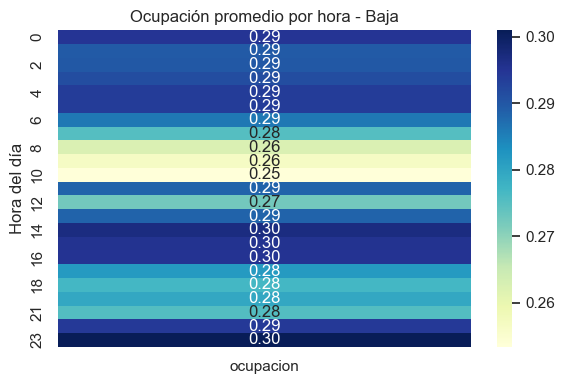

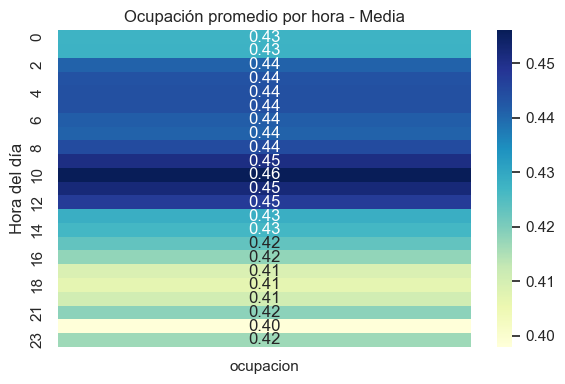

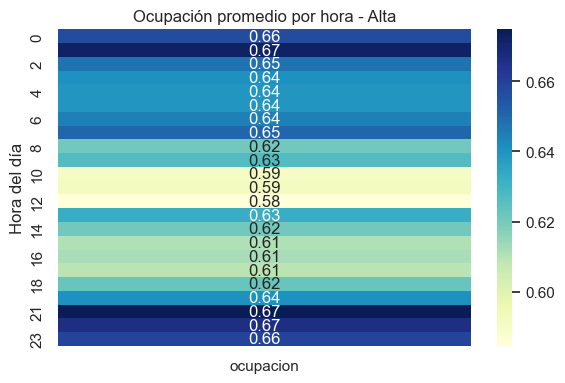

=== Mapas de calor: temperatura vs ocupaci√≥n promedio ===


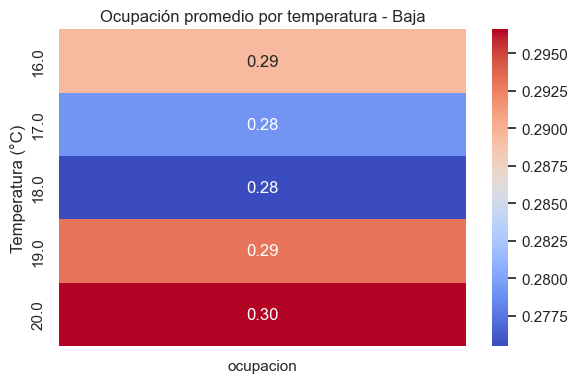

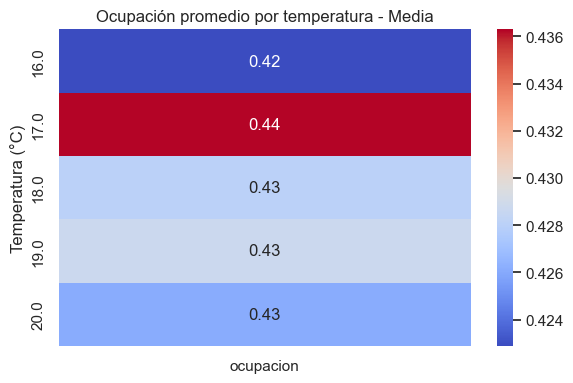

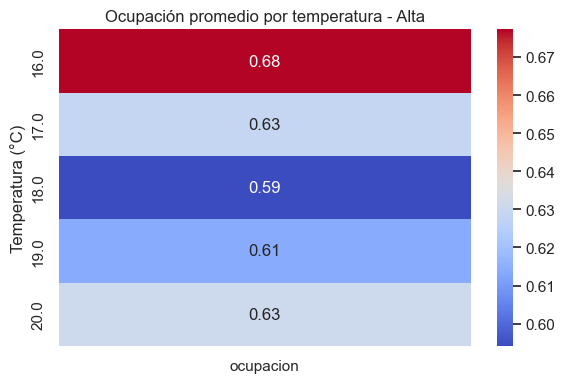

In [322]:
# ================================================
# 11. Mapas de calor por categor√≠a de ocupaci√≥n
# ================================================

# Aseguramos columnas correctas
df["hora"] = df["hora"].astype(int)
df["temp_c_redondeada"] = df["temp_c"].round()

# Filtrar datos v√°lidos
df_filtrado = df.dropna(subset=["ocupacion", "hora", "temp_c_redondeada", "categoria_ocupacion"])

# Obtener categor√≠as presentes
categorias = [c for c in labels if c in df_filtrado["categoria_ocupacion"].unique()]

# --- Mapas de calor por hora ---
print("=== Mapas de calor: hora vs ocupaci√≥n promedio ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    pivot_hora = subset.pivot_table(index="hora", values="ocupacion", aggfunc="mean")
    
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot_hora, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title(f"Ocupaci√≥n promedio por hora - {cat}")
    plt.ylabel("Hora del d√≠a")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

# --- Mapas de calor por temperatura ---
print("=== Mapas de calor: temperatura vs ocupaci√≥n promedio ===")
for cat in categorias:
    subset = df_filtrado[df_filtrado["categoria_ocupacion"] == cat]
    pivot_temp = subset.pivot_table(index="temp_c_redondeada", values="ocupacion", aggfunc="mean").sort_index()
    
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot_temp, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title(f"Ocupaci√≥n promedio por temperatura - {cat}")
    plt.ylabel("Temperatura (¬∞C)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()


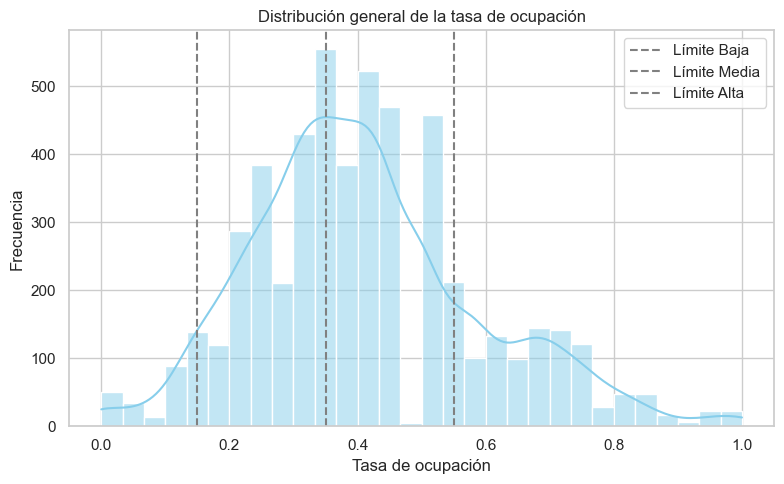

In [323]:

# ==========================================================
# VISUALIZACIONES
# ==========================================================

# --- 1Ô∏è‚É£ Histograma general de la tasa de ocupaci√≥n ---
plt.figure(figsize=(8,5))
sns.histplot(df['ocupacion'], bins=30, kde=True, color='skyblue')
plt.axvline(0.15, color='gray', linestyle='--', label='L√≠mite Baja')
plt.axvline(0.35, color='gray', linestyle='--', label='L√≠mite Media')
plt.axvline(0.55, color='gray', linestyle='--', label='L√≠mite Alta')
plt.title("Distribuci√≥n general de la tasa de ocupaci√≥n")
plt.xlabel("Tasa de ocupaci√≥n")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()





C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3624110146.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")


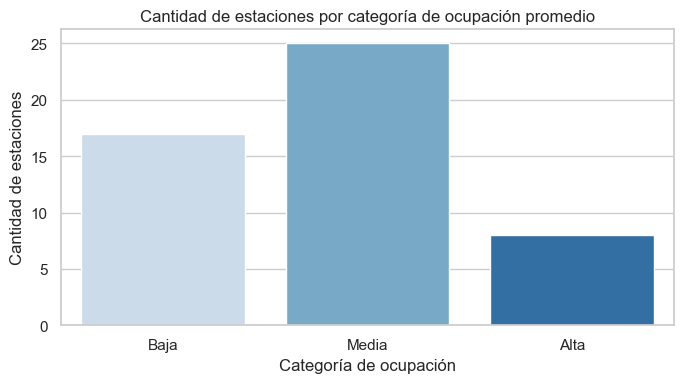

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\3624110146.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


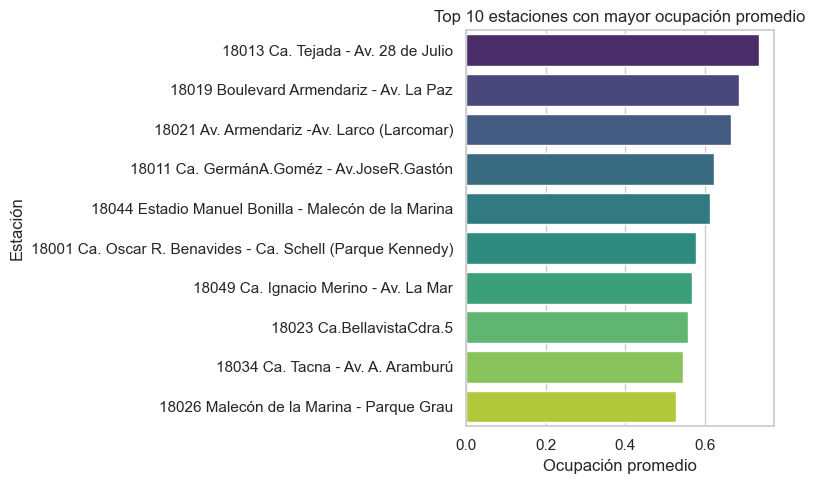

In [324]:

# ==========================================================
# OCUPACI√ìN PROMEDIO POR ESTACI√ìN Y CATEGORIZACI√ìN
# ==========================================================
station_summary = df.groupby('id_estacion').agg(
    nombre_estacion=('nombre_estacion', 'first'),
    mean_ocupacion=('ocupacion', 'mean'),
    obs=('id_estacion', 'count')
).reset_index()

# Clasificamos cada estaci√≥n seg√∫n su ocupaci√≥n promedio
bins = [0.15, 0.35, 0.55, 0.75]
labels = ['Baja','Media','Alta']
station_summary['ocup_cat_fixed'] = pd.cut(
    station_summary['mean_ocupacion'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)
# VISUALIZACI√ìN POR ESTACIONES


# --- 1Ô∏è‚É£ Conteo de estaciones por categor√≠a ---
conteo_estaciones = station_summary['ocup_cat_fixed'].value_counts().reindex(labels)

plt.figure(figsize=(7,4))
sns.barplot(x=conteo_estaciones.index, y=conteo_estaciones.values, palette="Blues")
plt.title("Cantidad de estaciones por categor√≠a de ocupaci√≥n promedio")
plt.xlabel("Categor√≠a de ocupaci√≥n")
plt.ylabel("Cantidad de estaciones")
plt.tight_layout()
plt.show()



# --- 3Ô∏è‚É£ Ranking de estaciones ---
top_estaciones = station_summary.sort_values('mean_ocupacion', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion', 
    y='nombre_estacion', 
    data=top_estaciones, 
    palette="viridis"
)
plt.title("Top 10 estaciones con mayor ocupaci√≥n promedio")
plt.xlabel("Ocupaci√≥n promedio")
plt.ylabel("Estaci√≥n")
plt.tight_layout()
plt.show()

C:\Users\curay\AppData\Local\Temp\ipykernel_4512\321513722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


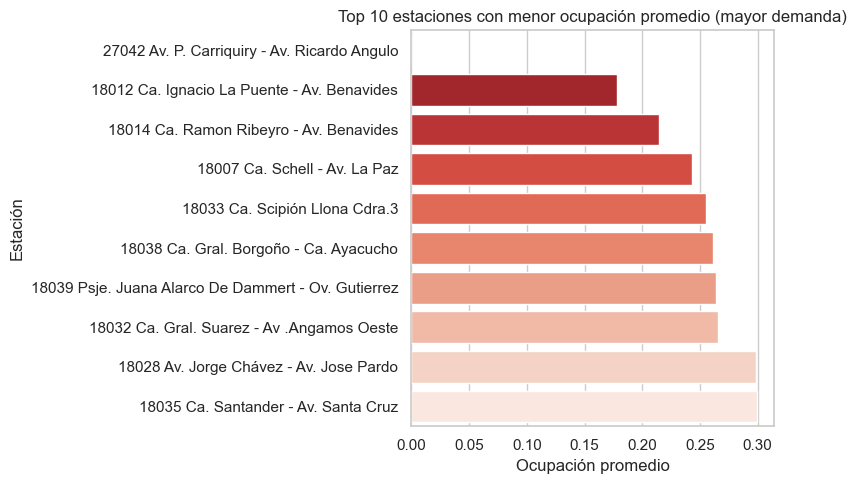

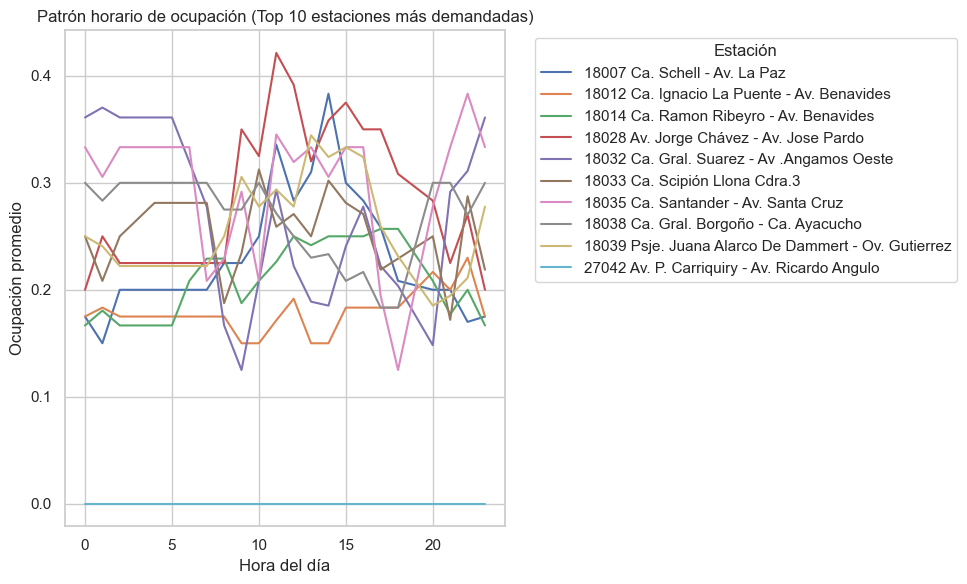

In [325]:
# ==========================================================
# 1Ô∏è‚É£ Estaciones con menor ocupaci√≥n promedio (alta demanda)
# ==========================================================
bottom_estaciones = station_summary.sort_values('mean_ocupacion', ascending=True).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    x='mean_ocupacion',
    y='nombre_estacion',
    data=bottom_estaciones,
    palette="Reds_r"  # colores invertidos: rojo = m√°s vac√≠a
)
plt.title("Top 10 estaciones con menor ocupaci√≥n promedio (mayor demanda)")
plt.xlabel("Ocupaci√≥n promedio")
plt.ylabel("Estaci√≥n")
plt.tight_layout()
plt.show()

# ==========================================================
# 2Ô∏è‚É£ Ocupaci√≥n por hora para estaciones de alta demanda
# ==========================================================
# Filtramos el dataset original solo para esas estaciones
df_high_demand = df[df['id_estacion'].isin(bottom_estaciones['id_estacion'])]

ocup_hora = df_high_demand.groupby(['nombre_estacion','hora']).agg(
    ocupacion_promedio=('ocupacion','mean')
).reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=ocup_hora, x='hora', y='ocupacion_promedio', hue='nombre_estacion')
plt.title("Patr√≥n horario de ocupaci√≥n (Top 10 estaciones m√°s demandadas)")
plt.xlabel("Hora del d√≠a")
plt.ylabel("Ocupaci√≥n promedio")
plt.legend(title="Estaci√≥n", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




Cantidad total de filas: 5250
Cantidad con avenida asignada: 5040
Cantidad sin avenida asignada: 210

Ejemplo de avenidas detectadas:
['Av. Pardo' 'Ca. Luis Schereiber Cdra' 'Ca. Madrid' 'Malec√≥n Cisneros'
 'Malec√≥n de la Marina' 'Malec√≥n de la Reserva' 'Ca. Tacna'
 'Av. Armendariz' 'Av. Nu√±ez de Balboa' 'Ca. Manco Capac']


C:\Users\curay\AppData\Local\Temp\ipykernel_4512\351019502.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


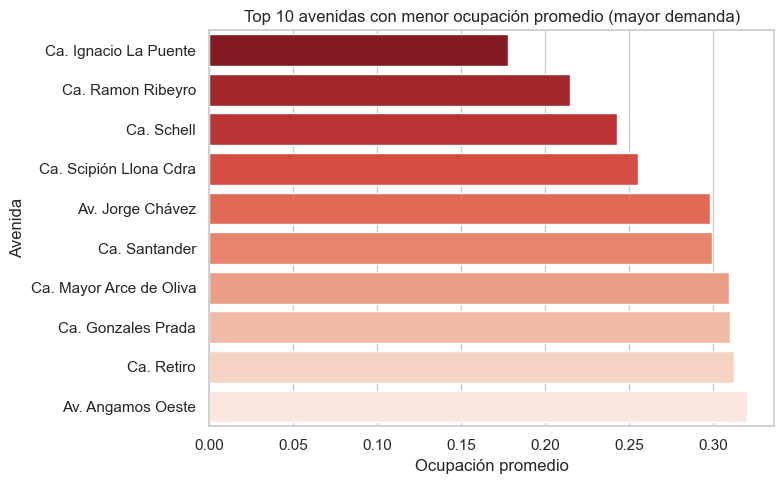

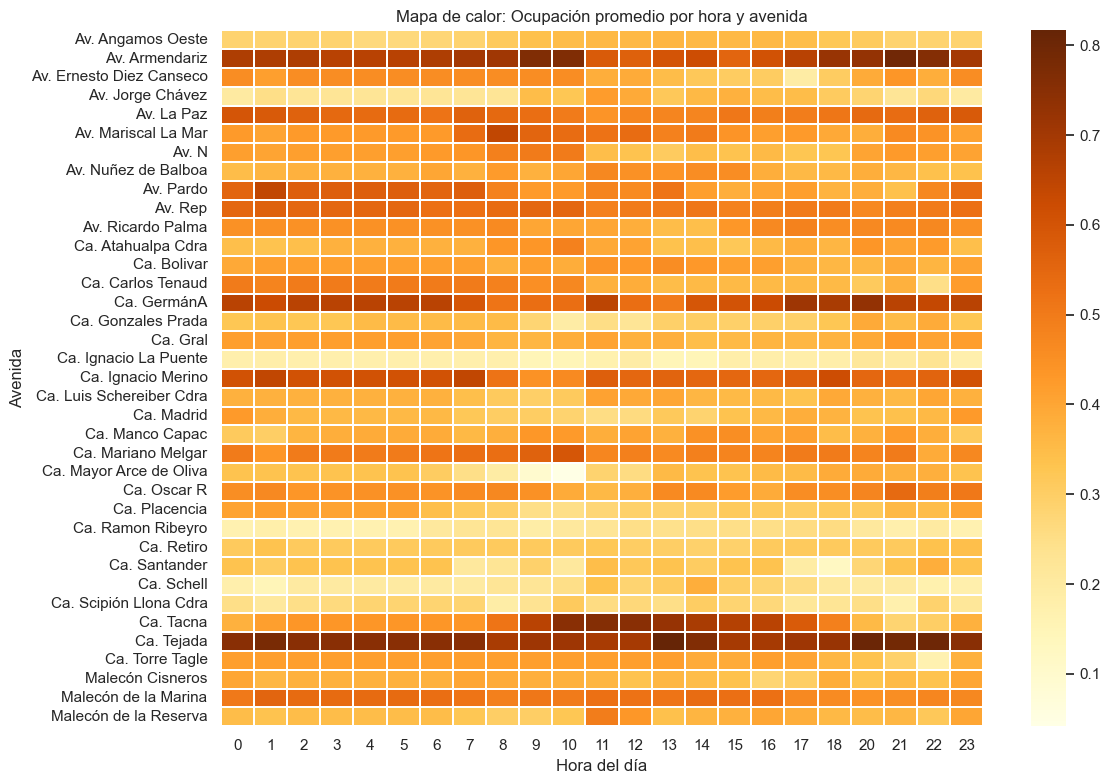

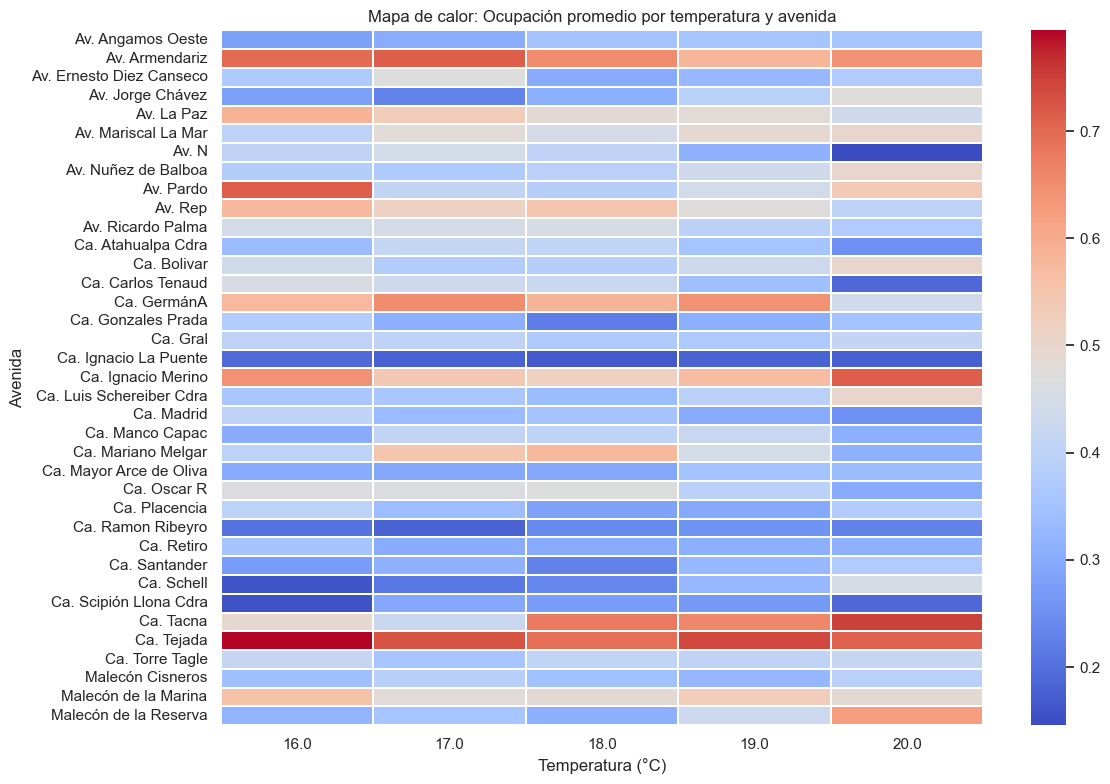

In [329]:
# ===============================================================
# üö≤ AN√ÅLISIS DE OCUPACI√ìN PROMEDIO POR AVENIDA - CITYBIKE (versi√≥n autom√°tica)
# ===============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1Ô∏è‚É£ Filtrado b√°sico de estaciones v√°lidas ---
min_obs = 40  # m√≠nimo de observaciones por estaci√≥n
station_summary = df.groupby('id_estacion')['ocupacion'].agg(['count', 'mean']).reset_index()
station_summary.rename(columns={'count': 'obs', 'mean': 'ocup_prom'}, inplace=True)

good_stations = station_summary[station_summary['obs'] >= min_obs]['id_estacion']
df_filtered = df[df['id_estacion'].isin(good_stations)].copy()

# --- 2Ô∏è‚É£ Detectar avenida a partir del nombre de estaci√≥n ---
# Intentamos extraer palabras clave como 'Av.', 'Ca.', 'Malec√≥n', 'Parque', etc.
df_filtered['avenida'] = df_filtered['nombre_estacion'].str.extract(
    r'((?:Av\.|Avenida|Ca\.|Calle|Malec√≥n|Parque)\s+[A-Za-z√Å√â√ç√ì√ö√°√©√≠√≥√∫√±√ë\s]+)'
)

# Limpieza b√°sica
df_filtered['avenida'] = df_filtered['avenida'].str.strip()

print("Cantidad total de filas:", len(df_filtered))
print("Cantidad con avenida asignada:", df_filtered['avenida'].notna().sum())
print("Cantidad sin avenida asignada:", df_filtered['avenida'].isna().sum())
print("\nEjemplo de avenidas detectadas:")
print(df_filtered['avenida'].dropna().unique()[:10])

# --- 3Ô∏è‚É£ Eliminar filas sin avenida ---
df_filtered = df_filtered.dropna(subset=['avenida'])

# --- 4Ô∏è‚É£ Promedio de ocupaci√≥n por avenida ---
avenida_stats = (
    df_filtered.groupby('avenida')['ocupacion']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

# --- 5Ô∏è‚É£ Top 10 de menor ocupaci√≥n promedio (mayor demanda) ---
top10_baja_ocup = avenida_stats.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10_baja_ocup,
    x='ocupacion',
    y='avenida',
    palette='Reds_r'
)
plt.title("Top 10 avenidas con menor ocupaci√≥n promedio (mayor demanda)")
plt.xlabel("Ocupaci√≥n promedio")
plt.ylabel("Avenida")
plt.tight_layout()
plt.show()

# --- 6Ô∏è‚É£ Mapa de calor: ocupaci√≥n promedio por hora y avenida ---
pivot_hora = df_filtered.pivot_table(
    index='avenida',
    columns='hora',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_hora.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_hora, cmap='YlOrBr', linewidths=0.3)
    plt.title("Mapa de calor: Ocupaci√≥n promedio por hora y avenida")
    plt.xlabel("Hora del d√≠a")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("‚ö†Ô∏è No hay datos suficientes para el mapa de calor por hora.")

# --- 7Ô∏è‚É£ Mapa de calor: ocupaci√≥n promedio por temperatura y avenida ---
df_filtered['temp_redondeada'] = df_filtered['temp_c'].round()
pivot_temp = df_filtered.pivot_table(
    index='avenida',
    columns='temp_redondeada',
    values='ocupacion',
    aggfunc='mean'
).dropna(how='all')

if not pivot_temp.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_temp, cmap='coolwarm', linewidths=0.3)
    plt.title("Mapa de calor: Ocupaci√≥n promedio por temperatura y avenida")
    plt.xlabel("Temperatura (¬∞C)")
    plt.ylabel("Avenida")
    plt.tight_layout()
    plt.show()
else:
    print("‚ö†Ô∏è No hay datos suficientes para el mapa de calor por temperatura.")
